In [302]:
!pip install -r requirements.txt

In [303]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import json
from node2vec import Node2Vec

In [3]:
df_responses = pd.read_csv("haaleandja/data_kandidaatide_vastused.csv")

In [4]:
party_to_short = {
    "Reformierakond": "REF",
    "SDE": "SDE",
    "EKRE": "EKRE",
    "Keskerakond": "KE",
    "Parempoolsed": "PAR",
    "Isamaa": "I",
    "Rohelised": "ROH",
    "Eesti 200": "E200",
    "Eestimaa Ühendatud Vasakpartei": "VAS",
    "Üksikkandidaat": "ÜKS"
}
party_to_color = {
    "REF": "yellow",
    "SDE": "red",
    "EKRE": "black",
    "KE": "green",
    "PAR": "darkorange",
    "I": "blue",
    "ROH": "lime",
    "E200": "aqua",
    "VAS": "darkred",
    "ÜKS": "gray"
}
df_responses["party_short"] = df_responses.party.map(party_to_short)
df_responses["color"] = df_responses.party_short.map(party_to_color)

In [5]:
n_to_label = pd.read_csv("haaleandja/kysimused.csv").set_index("id").to_dict()

In [6]:
# Q_{n} label in df_responses is n_to_label[n]

In [7]:
qcols = [c for c in df_responses.columns if "Q_" in c]

In [8]:
df_responses[qcols]

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_20,Q_21,Q_22,Q_23,Q_24,Q_25,Q_26,Q_27,Q_28,Q_29
0,2.0,4.0,2.0,3.0,NaN,3.0,1.0,NaN,1.0,4.0,...,4.0,1.0,1.0,1.0,2.0,4.0,1.0,4.0,4.0,4.0
1,2.0,1.0,3.0,3.0,2.0,3.0,3.0,NaN,2.0,4.0,...,3.0,NaN,1.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
2,2.0,1.0,1.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,...,3.0,3.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0
3,2.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,...,3.0,3.0,1.0,2.0,2.0,3.0,4.0,2.0,4.0,2.0
4,2.0,1.0,1.0,4.0,1.0,2.0,3.0,2.0,1.0,3.0,...,3.0,1.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,1.0,1.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
612,2.0,1.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,1.0,...,2.0,2.0,1.0,2.0,3.0,1.0,4.0,4.0,1.0,2.0
613,3.0,1.0,1.0,3.0,2.0,3.0,1.0,4.0,1.0,4.0,...,3.0,2.0,1.0,2.0,2.0,4.0,4.0,3.0,4.0,3.0
614,3.0,2.0,4.0,3.0,4.0,3.0,3.0,1.0,2.0,3.0,...,2.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0


## PCA on responders

In [9]:
mean_value = df_responses[qcols].mean().mean()

In [10]:
X = df_responses[qcols].fillna(value=mean_value)
y = df_responses["color"]
labels = df_responses["party"]

In [11]:
partyToSubdf = {k: df for k, df in df_responses.groupby("party_short")}

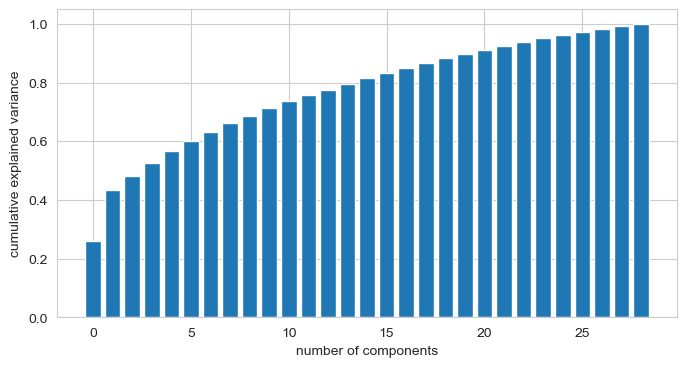

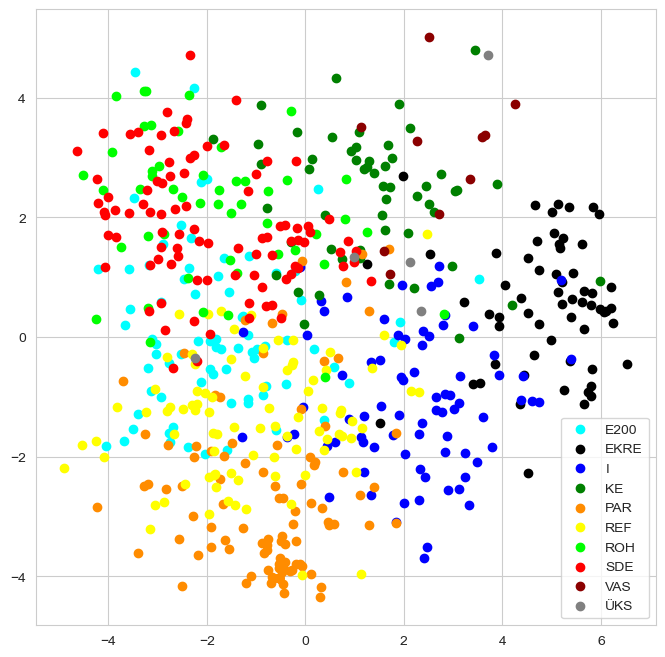

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
Xt = pca.fit_transform(X)

plt.rcParams["figure.figsize"] = (8,4)
plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

plt.rcParams["figure.figsize"] = (8,8)
for party in partyToSubdf:
    idx = partyToSubdf[party].index
    plt.scatter(Xt[idx,0], Xt[idx,1], c=party_to_color[party], label=party)
plt.legend()
plt.show()

## Responses to graph links

In [211]:
df_responses[qcols]

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_20,Q_21,Q_22,Q_23,Q_24,Q_25,Q_26,Q_27,Q_28,Q_29
0,2.0,4.0,2.0,3.0,NaN,3.0,1.0,NaN,1.0,4.0,...,4.0,1.0,1.0,1.0,2.0,4.0,1.0,4.0,4.0,4.0
1,2.0,1.0,3.0,3.0,2.0,3.0,3.0,NaN,2.0,4.0,...,3.0,NaN,1.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
2,2.0,1.0,1.0,4.0,3.0,4.0,3.0,3.0,2.0,3.0,...,3.0,3.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0
3,2.0,1.0,1.0,3.0,3.0,3.0,4.0,2.0,2.0,3.0,...,3.0,3.0,1.0,2.0,2.0,3.0,4.0,2.0,4.0,2.0
4,2.0,1.0,1.0,4.0,1.0,2.0,3.0,2.0,1.0,3.0,...,3.0,1.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,1.0,1.0,1.0,3.0,1.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,1.0,2.0,4.0,4.0,3.0,3.0,4.0,3.0
612,2.0,1.0,4.0,4.0,4.0,3.0,4.0,1.0,3.0,1.0,...,2.0,2.0,1.0,2.0,3.0,1.0,4.0,4.0,1.0,2.0
613,3.0,1.0,1.0,3.0,2.0,3.0,1.0,4.0,1.0,4.0,...,3.0,2.0,1.0,2.0,2.0,4.0,4.0,3.0,4.0,3.0
614,3.0,2.0,4.0,3.0,4.0,3.0,3.0,1.0,2.0,3.0,...,2.0,2.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0


In [212]:
curr_idx = 0
(df_responses[qcols].loc[curr_idx] - df_responses[qcols].loc[curr_idx:]).mean()

Q_1    -0.586885
Q_2     1.771987
Q_3    -0.429739
Q_4     0.295935
Q_5          NaN
Q_6     0.181077
Q_7    -1.684729
Q_8          NaN
Q_9    -1.083062
Q_10    1.029508
Q_11    0.675000
Q_12         NaN
Q_13    0.105960
Q_14    1.225191
Q_15   -1.427184
Q_16         NaN
Q_17         NaN
Q_18    1.618033
Q_19   -0.546053
Q_20    0.853420
Q_21   -1.071307
Q_22   -0.905316
Q_23   -1.385502
Q_24   -0.320534
Q_25    1.306533
Q_26   -1.920000
Q_27    0.925373
Q_28    0.900000
Q_29    1.569787
dtype: float64

In [217]:
result_dict = {}
for i in df_responses.index:
    # name = df_responses["name"].loc[i]
    col = (df_responses[qcols].loc[i] - df_responses[qcols]).pow(2).mean(axis=1)
    result_dict[i] = col

In [257]:
adj_matrix = pd.DataFrame(result_dict)#.set_index(df_responses["name"])
adj_matrix = 1/adj_matrix
np.fill_diagonal(adj_matrix.values, np.nan)
max_noninf = adj_matrix.stack()[adj_matrix.stack() < np.inf].max()
adj_matrix.replace([np.inf], max_noninf, inplace=True)

### Visualize proximity of a politician to others

In [258]:
# problem with Tarmo Tamm as there's 2
def get_id(name):
    return df_responses[df_responses["name"] == name].iloc[0].name

In [259]:
name = "Riina Solman"
id = get_id(name)
most_similar = adj_matrix[id].sort_values(ascending=False)
most_similar = pd.DataFrame(most_similar).merge(df_responses[["color", "name", "party_short"]], left_index=True, right_index=True)

In [260]:
import matplotlib.patches as mpatches
handles = []
for p, c in party_to_color.items():
    handles.append(mpatches.Patch(color=c, label=p))

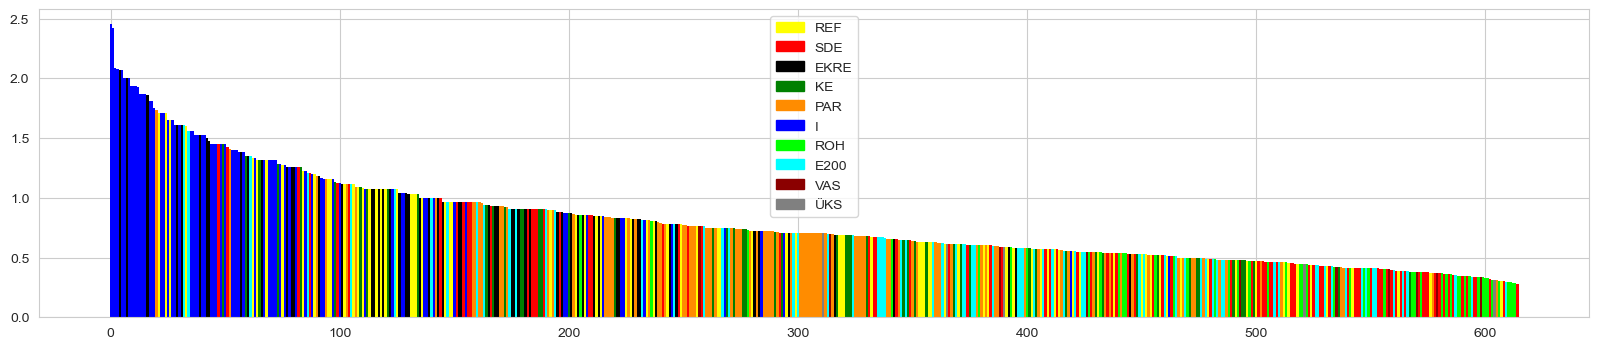

In [261]:
plt.rcParams["figure.figsize"] = (20,4)
plt.bar(range(most_similar.shape[0]), most_similar[id], color=most_similar["color"], width=1, linewidth=0, label=most_similar["party_short"])
plt.legend(handles=handles)
plt.show()

### Create graph

In [304]:
G = nx.from_pandas_adjacency((adj_matrix/adj_matrix.max().max()).pow(0.5))
#responses_by_name = df_responses.set_index("name")
id_to_name = df_responses["name"]
nx.set_node_attributes(G,
                       {
                           "name": df_responses["name"].to_dict(),
                           "fraction": df_responses["party_short"].to_dict(),
                           "color": df_responses["color"].to_dict(),
                       })

In [312]:
G.degree(weight="weight") # wtf

DegreeView({0: nan, 1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan, 8: nan, 9: nan, 10: nan, 11: nan, 12: nan, 13: nan, 14: nan, 15: nan, 16: nan, 17: nan, 18: nan, 19: nan, 20: nan, 21: nan, 22: nan, 23: nan, 24: nan, 25: nan, 26: nan, 27: nan, 28: nan, 29: nan, 30: nan, 31: nan, 32: nan, 33: nan, 34: nan, 35: nan, 36: nan, 37: nan, 38: nan, 39: nan, 40: nan, 41: nan, 42: nan, 43: nan, 44: nan, 45: nan, 46: nan, 47: nan, 48: nan, 49: nan, 50: nan, 51: nan, 52: nan, 53: nan, 54: nan, 55: nan, 56: nan, 57: nan, 58: nan, 59: nan, 60: nan, 61: nan, 62: nan, 63: nan, 64: nan, 65: nan, 66: nan, 67: nan, 68: nan, 69: nan, 70: nan, 71: nan, 72: nan, 73: nan, 74: nan, 75: nan, 76: nan, 77: nan, 78: nan, 79: nan, 80: nan, 81: nan, 82: nan, 83: nan, 84: nan, 85: nan, 86: nan, 87: nan, 88: nan, 89: nan, 90: nan, 91: nan, 92: nan, 93: nan, 94: nan, 95: nan, 96: nan, 97: nan, 98: nan, 99: nan, 100: nan, 101: nan, 102: nan, 103: nan, 104: nan, 105: nan, 106: nan, 107: nan, 108: nan, 109: nan

In [289]:
edge_attrs = nx.get_edge_attributes(G, "weight")
edge_attrs = {k: v for k, v in edge_attrs.items() if k[0] != k[1] and v != np.inf and k[0] != ""}  # remove reflexive
edge_attrs = pd.Series(edge_attrs)  #
edge_attrs /= edge_attrs.max()  # scale to max
# filter
#selected_edges = edge_attrs[edge_attrs > 0.8] # maybe top5 for each?
top_n_nodes_per_edge = 999
selected_edges = edge_attrs.reset_index().groupby("level_0").head(top_n_nodes_per_edge).set_index(
    ["level_0", "level_1"]).rename({0: "value"}).squeeze()
selected_edges = selected_edges.sample(len(G.nodes)*4)

In [290]:
#labels = df_responses["name"].loc[list(G.nodes)].to_list()
#color_array = df_responses["color"].loc[list(G.nodes)].to_list()

In [291]:
#pos = nx.drawing.layout.spring_layout(G, k=5/math.sqrt(len(G.nodes)))

In [275]:
#nx.draw(G, pos=pos, node_color=color_array, edgelist=selected_edges.index, width=np.asarray(selected_edges.values)**3, node_size=600)
#nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=24, verticalalignment="bottom")
#plt.savefig("voter_graph.png", format="PNG")